Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),  # Resize images to the specified size
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Processing /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis...
Found 114 image(s) in /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Processing /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma...
Found 376 image(s) in /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Processing /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma...
Found 95 image(s) in /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Processing /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The Internati

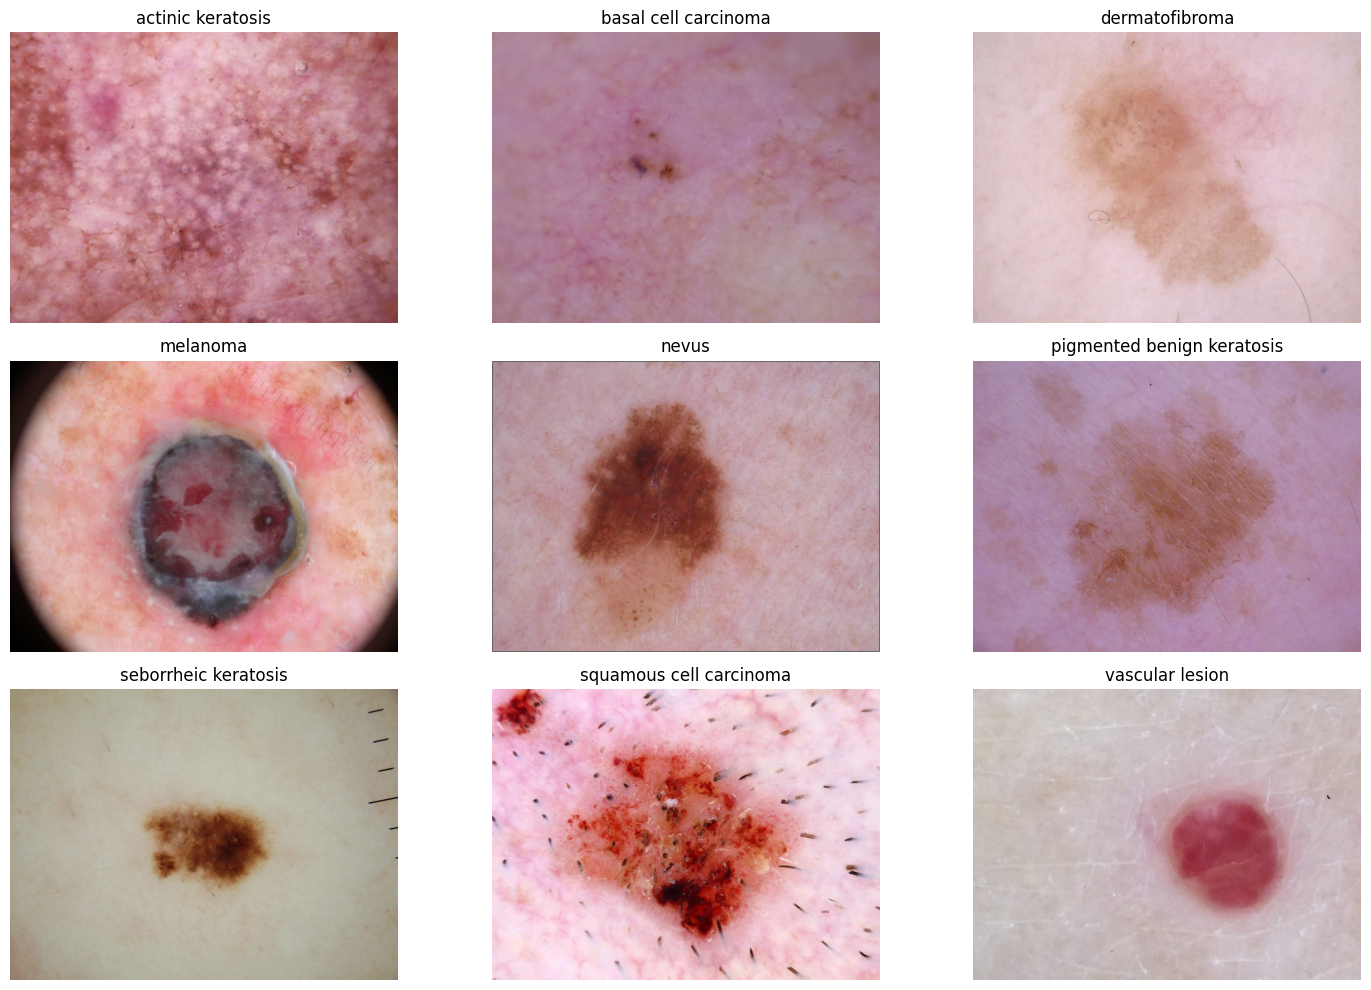

In [9]:
import matplotlib.pyplot as plt
import os
import PIL


# Number of classes
num_classes = 9

# Setting up the figure for plotting
plt.figure(figsize=(15, 10))

# Iterate over each class
for i in range(num_classes):
    # Get the class directory
    class_dir = os.path.join(data_dir_train, class_names[i])

    # Debugging: Print the current class directory
    print(f"Processing {class_dir}...")

    # Get the list of image files in the class directory
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Debugging: Print how many images were found
    print(f"Found {len(image_files)} image(s) in {class_dir}")

    # Check if there are any images in the directory
    if len(image_files) == 0:
        print(f"No images found in {class_dir}. Skipping...")
        continue

    # Open the first image file
    img = PIL.Image.open(os.path.join(class_dir, image_files[0]))

    # Plotting
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(class_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set the input shape
input_shape = (180, 180, 3)  # Height x Width x Color Channels

# Create the model
model = models.Sequential([
    # Rescaling layer to normalize pixel values
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),

    # Convolutional Layer #1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Layer #2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Layer #3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Dense Layer #1
    layers.Dense(128, activation='relu'),

    # Output layer with 9 neurons (for 9 classes), using softmax activation function
    layers.Dense(9, activation='softmax')
])







### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 577s 2s/step - loss: 1.9415 - accuracy: 0.2824 - val_loss: 1.7919 - val_accuracy: 0.3714
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5842 - accuracy: 0.4487 - val_loss: 1.4486 - val_accuracy: 0.5168
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4239 - accuracy: 0.4967 - val_loss: 1.4130 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - 2s 33ms/step - loss: 1.3670 - accuracy: 0.5346 - val_loss: 1.4453 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.2838 - accuracy: 0.5407 - val_loss: 1.4234 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 2s 33ms/step - loss: 1.1923 - accuracy: 0.5703 - val_loss: 1.4122 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.1378 - accuracy: 0.5938 - val_loss: 1.5082 - val_accuracy: 0.5078
Epoch 8/20
56

### Visualizing training results

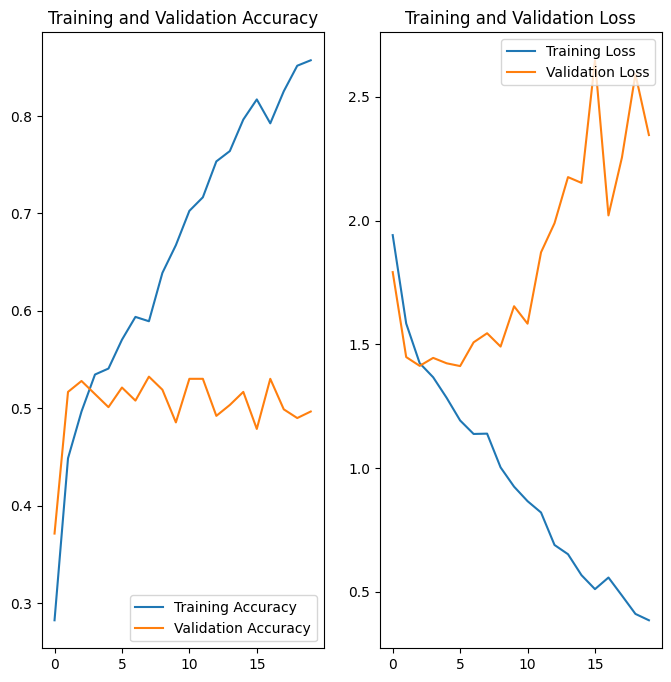

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Training and Validation Accuracy:

The training accuracy is steadily increasing as the number of epochs increases, which is a good sign that your model is learning from the training data.
The validation accuracy, however, is not improving at the same rate as the training accuracy. It appears to be fluctuating and, on average, is much lower than the training accuracy.
Training and Validation Loss:

The training loss is decreasing, which is consistent with an improving model.
The validation loss decreases initially but then starts to increase, indicating the model is beginning to overfit to the training data.
Analysis:
The model shows signs of overfitting. This can be inferred from the fact that the training accuracy is increasing and the training loss is decreasing, but the validation accuracy is not keeping up and the validation loss is rising as the epochs go by. Overfitting happens when the model learns patterns that are specific to the training data, which do not generalize to new, unseen data.
Data Augmentation Strategy:
To mitigate overfitting, you can implement a data augmentation strategy. Data augmentation artificially increases the size and diversity of the training dataset by applying various transformations to the existing images, which can help the model generalize better.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# Applying data augmentation to the training dataset
train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=AUTOTUNE)


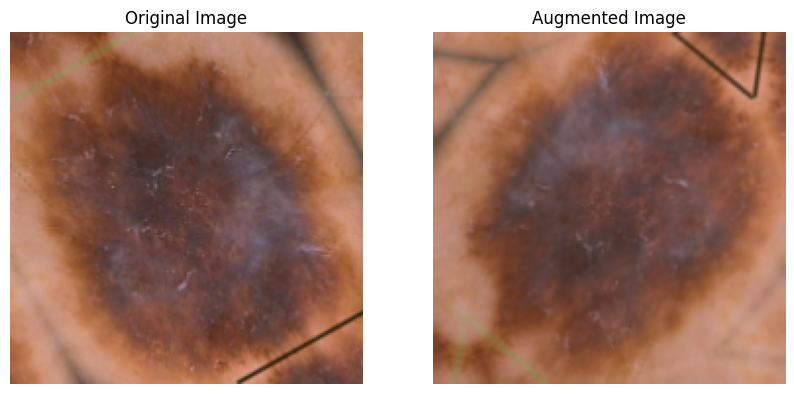

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
import matplotlib.pyplot as plt
import numpy as np



# Retrieve a batch of images from the training dataset
for images, _ in train_ds.take(1):
    # Take the first image from the batch
    original_image = images[0].numpy().astype("uint8")
    # Apply data augmentation to the image
    augmented_image = data_augmentation(images)[0].numpy().astype("uint8")

    # Visualize the original and augmented image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title('Augmented Image')
    plt.axis('off')

    plt.show()
    break  # We only need one instance, so break after the first batch


### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

import tensorflow as tf
from tensorflow.keras import layers, models

# Define the input shape
input_shape = (180, 180, 3)  # Adjust as per your image dimensions

# Define the model
model = models.Sequential([
    # Input and Rescaling layer (normalizes pixel values)
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),

    # Convolutional Layer #1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Layer #2 and Dropout
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout layer to mitigate overfitting

    # Convolutional Layer #3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the layer and add Dropout
    layers.Flatten(),
    layers.Dropout(0.5),  # More Dropout

    # Fully connected layer
    layers.Dense(128, activation='relu'),

    # Output layer with 9 neurons (one for each class)
    layers.Dense(9, activation='softmax')
])









### Compiling the model

In [19]:
## Your code goes here
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
# Summary of the model
# Assuming you have already defined train_ds and val_ds
# Train the model
epochs = 20  # You can adjust the number of epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

model.summary()

Epoch 1/20
56/56 [==============================] - 17s 260ms/step - loss: 2.2623 - accuracy: 0.1987 - val_loss: 2.0969 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 15s 264ms/step - loss: 1.9838 - accuracy: 0.2606 - val_loss: 1.9174 - val_accuracy: 0.2975
Epoch 3/20
56/56 [==============================] - 14s 258ms/step - loss: 1.8650 - accuracy: 0.3030 - val_loss: 1.7577 - val_accuracy: 0.4183
Epoch 4/20
56/56 [==============================] - 15s 263ms/step - loss: 1.7758 - accuracy: 0.3700 - val_loss: 1.7178 - val_accuracy: 0.3714
Epoch 5/20
56/56 [==============================] - 15s 265ms/step - loss: 1.5625 - accuracy: 0.4515 - val_loss: 1.4666 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 14s 258ms/step - loss: 1.5242 - accuracy: 0.4581 - val_loss: 1.4482 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 15s 264ms/step - loss: 1.4410 - accuracy: 0.4900 - val_loss: 1.3969 - val_accuracy: 0.5369

### Visualizing the results

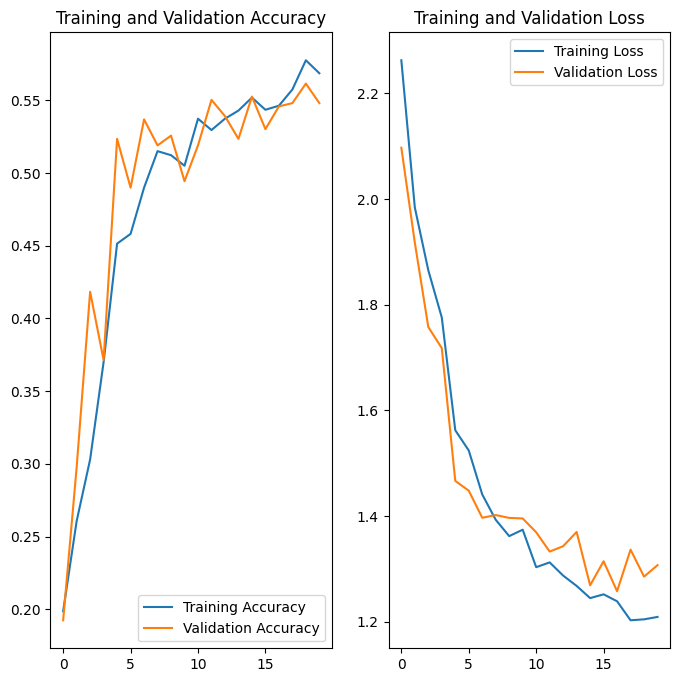

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Training Accuracy:

It generally increases over time, which indicates that the model is learning and improving its ability to recognize patterns in the training data.
Validation Accuracy:

The validation accuracy also increases, but it's consistently lower than the training accuracy. It exhibits some fluctuations, which is common in validation metrics due to the variability in the unseen data. The overall trend, though, is positive.
Training Loss:

It decreases significantly, which is expected as the model's accuracy improves.
Validation Loss:

The validation loss decreases along with the training loss, which is good. It shows some upward spikes, which might suggest that the model's performance on the validation set is less stable. However, it does not show a clear upward trend as the number of epochs increases, which is encouraging in terms of the model not overfitting.
Summary:
The model's training and validation accuracy are converging, and the training and validation loss are also converging. This is a sign that the model is not overfitting as much as it did initially. There is still a gap between the training and validation accuracy, which is normal to some extent, but it should not be very large. The model seems to be on the right track towards generalizing well, but there might be room for further optimization, such as:

Adjusting model complexity, perhaps by adding or removing layers or changing the number of neurons.
Tuning hyperparameters, including learning rate, batch size, or epochs.
Further improving data preprocessing or augmentation to better capture the variance in the data.
Regularization techniques other than dropout, such as L1/L2 regularization, might be explored if overfitting persists.
If the validation loss starts to increase consistently in future epochs, it would be a stronger indication of overfitting.
Overall, the model appears to be performing adequately, but you should continue to monitor these trends as you continue to train for additional epochs or make adjustments to the model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class actinic keratosis: 114 images
Class vascular lesion: 139 images
Class squamous cell carcinoma: 181 images
Class seborrheic keratosis: 77 images
Class nevus: 357 images
Class melanoma: 438 images
Class basal cell carcinoma: 376 images
Class pigmented benign keratosis: 462 images
Class dermatofibroma: 95 images


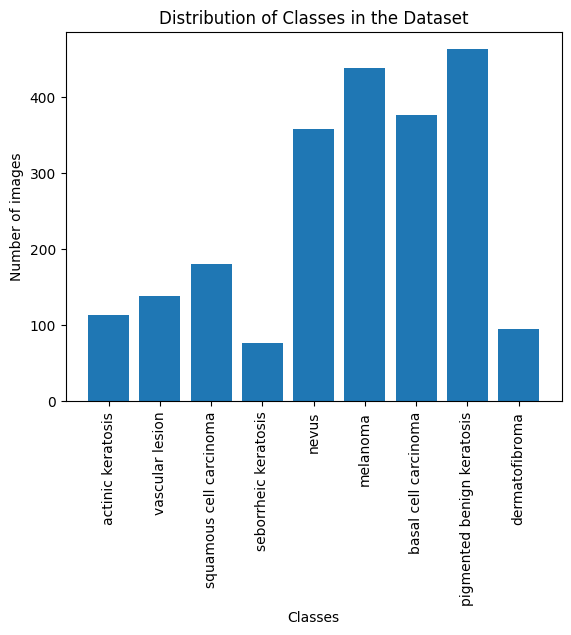

In [22]:
## Your code goes here.

import os
from collections import Counter


class_names = os.listdir(data_dir_train)  # This will list the names of the subdirectories/classes
class_counts = Counter()

# Iterate over each class directory and count the images
for class_name in class_names:
    class_dir = os.path.join(data_dir_train, class_name)
    # Count the number of image files in the class directory
    class_counts[class_name] = len([entry for entry in os.listdir(class_dir)
                                    if os.path.isfile(os.path.join(class_dir, entry))])

# Display the distribution of classes
for class_name, count in class_counts.items():
    print(f'Class {class_name}: {count} images')

# If you would like to visualize this distribution, you can use a bar chart:
import matplotlib.pyplot as plt

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Distribution of Classes in the Dataset')
plt.xticks(rotation=90)  # Rotate class names for better readability if necessary
plt.show()


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Class pigmented benign keratosis: 462 images and Class basal cell carcinoma: 376 images dominates the samples and Class seborrheic keratosis: 77 images has least samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
import Augmentor


for class_name in class_names:
    # Create a new path object for the class directory
    class_path = data_dir_train / class_name
    # Instantiate a Pipeline object for the current class directory
    p = Augmentor.Pipeline(str(class_path))
    # Define the augmentation operations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # TODO: Add more augmentation operations as needed
    # Execute the operations by sampling 500 times for the current class
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7894C2F26530>: 100%|██████████| 500/500 [00:20<00:00, 24.43 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7894D01892D0>: 100%|██████████| 500/500 [00:19<00:00, 25.16 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7894B0347A90>: 100%|██████████| 500/500 [00:17<00:00, 28.03 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7894D0223040>: 100%|██████████| 500/500 [00:40<00:00, 12.29 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7894D0460070>: 100%|██████████| 500/500 [01:29<00:00,  5.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78947213BA00>: 100%|██████████| 500/500 [01:30<00:00,  5.52 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7894D0067F10>: 100%|██████████| 500/500 [00:18<00:00, 27.51 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78947214D630>: 100%|██████████| 500/500 [00:20<00:00, 24.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7894D0421750>: 100%|██████████| 500/500 [00:18<00:00, 26.39 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
import os
import glob

# Assuming 'data_dir_train' is already defined and is a Path object, convert it to a string
data_dir_train_str = str(data_dir_train)
path_list = [x for x in glob.glob(os.path.join(data_dir_train_str, '*', 'output', '*.jpg'))]
print(path_list)


['/content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_3dadb073-ba8b-49a3-a7ce-686b1e29ab44.jpg', '/content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026709.jpg_30bba4f6-c029-4db4-b152-400087fe07c5.jpg', '/content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_9b6e11c5-a893-464a-8164-03b008a35a56.jpg', '/content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_0bd55ec9-b928-40a0-908e-b8ca75e754f0.jpg', '/content/gdrive/MyDrive/melonoma/CNN_assignment/Skin cancer ISIC The International

In [34]:
import os
import glob

# Assuming 'data_dir_train' is already defined and is a Path object, convert it to a string
data_dir_train_str = str(data_dir_train)
# This will create a list of class names (lesions) from the paths of the augmented images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train_str, '*','output', '*.jpg'))]
print(lesion_list_new)


['actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic ker

In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2.copy()

In [39]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
nevus                         500
melanoma                      500
basal cell carcinoma          500
pigmented benign keratosis    500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [44]:
## your code goes here
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the input shape
input_shape = (img_height, img_width, 3)  # Adjust as per your dataset

# Input layer
inputs = tf.keras.Input(shape=input_shape)

# Normalization layer
normalized = layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Convolutional and Pooling layers
x = layers.Conv2D(32, 3, activation='relu')(normalized)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)

# Flatten and Dense layers
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Output layer
outputs = layers.Dense(9, activation='softmax')(x)  # Adjust the number of units based on your number of classes

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)




#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

#### **Todo:**  Train your model

In [46]:
epochs = 30  # You can adjust the number of epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

model.summary()

Epoch 1/30
169/169 [==============================] - 43s 242ms/step - loss: 1.8569 - accuracy: 0.2997 - val_loss: 1.4575 - val_accuracy: 0.4514
Epoch 2/30
169/169 [==============================] - 41s 234ms/step - loss: 1.3928 - accuracy: 0.4757 - val_loss: 1.3433 - val_accuracy: 0.4952
Epoch 3/30
169/169 [==============================] - 41s 238ms/step - loss: 1.2225 - accuracy: 0.5564 - val_loss: 1.1345 - val_accuracy: 0.5880
Epoch 4/30
169/169 [==============================] - 41s 233ms/step - loss: 1.0126 - accuracy: 0.6389 - val_loss: 1.1640 - val_accuracy: 0.5828
Epoch 5/30
169/169 [==============================] - 42s 239ms/step - loss: 0.8799 - accuracy: 0.6786 - val_loss: 0.9938 - val_accuracy: 0.6481
Epoch 6/30
169/169 [==============================] - 41s 233ms/step - loss: 0.7052 - accuracy: 0.7450 - val_loss: 1.1708 - val_accuracy: 0.6021
Epoch 7/30
169/169 [==============================] - 44s 252ms/step - loss: 0.5669 - accuracy: 0.7980 - val_loss: 0.8390 - val_ac

#### **Todo:**  Visualize the model results

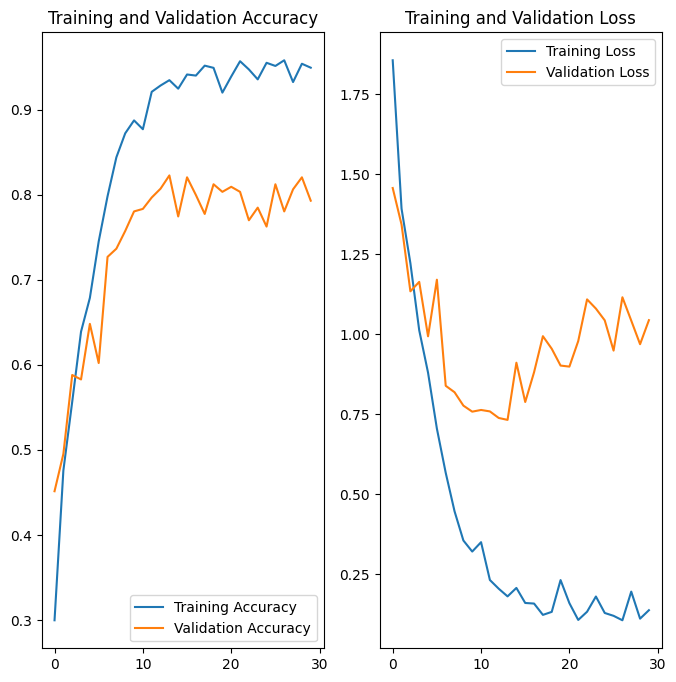

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The graphs show the training and validation accuracy and loss over a number of epochs after performing data augmentation.

Observations:

Training Accuracy: It increases over time and appears to be stabilizing at a high level, which is a good sign that the model is learning effectively from the augmented training data.
Validation Accuracy: There's a gap between training and validation accuracy, but the validation accuracy seems to be increasing and showing less volatility towards the later epochs, which may suggest that the model is generalizing better after augmentation.
Training Loss: The training loss decreases significantly, which typically correlates with an increase in accuracy.
Validation Loss: Initially, the validation loss decreases, but it experiences some fluctuations. However, towards the end of the training, it seems to be plateauing and not increasing, unlike the pre-augmentation scenario where it was trending upwards.
Did Augmentation Help?

The augmentation seems to have had a positive effect. While there is still a notable gap between training and validation accuracy, which suggests some overfitting, the model is performing better on the validation data compared to the pre-augmentation model. This is evidenced by the generally improved validation accuracy and more stable validation loss.

The validation metrics are less erratic, indicating that the augmented dataset has helped the model learn features that are more generalizable to unseen data. The model is likely benefiting from the increased variation in the training data, which helps prevent overfitting to the original training set.

However, if the gap between training and validation accuracy is still significant, you might need to consider additional strategies like further tuning the model, adding dropout layers, or even using regularization techniques. It’s also important to ensure that the model has been trained for a sufficient number of epochs and that the learning rate is appropriately set to allow for convergence.






